In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import matplotlib.image as image

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
87610,00021647_000.png,No Finding,0,21647,62,M,PA,2992,2991,0.143,0.143,NaN
86683,00021377_010.png,Pneumothorax,10,21377,52,M,PA,2992,2991,0.143,0.143,NaN
79810,00019605_006.png,Infiltration|Nodule,6,19605,29,F,AP,2500,2048,0.168,0.168,NaN


In [3]:
# The shape of the original data
all_xray_df.shape

(112120, 12)

The data contains **112120** rows and **12** columns

In [4]:
# List of the names of columns of the dataset 
all_xray_df.columns.tolist()

['Image Index',
 'Finding Labels',
 'Follow-up #',
 'Patient ID',
 'Patient Age',
 'Patient Gender',
 'View Position',
 'OriginalImage[Width',
 'Height]',
 'OriginalImagePixelSpacing[x',
 'y]',
 'Unnamed: 11']

In order to make the EDA easier, we will use the column **"Finding Labels"** will be used to create a column per disease with binary flag.

In [5]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# The shape of the modified dataset
all_xray_df.shape

(112120, 27)

In [7]:
# The presence of disease in the dataset
all_xray_df[all_labels].sum() / len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

**OBSERVATION-1**  
Here we see that the most present label is No Finding (53%).  
Pneumonia is only reperesented by (1.2%).

[Text(0, 0.5, 'Number of Images with Label')]

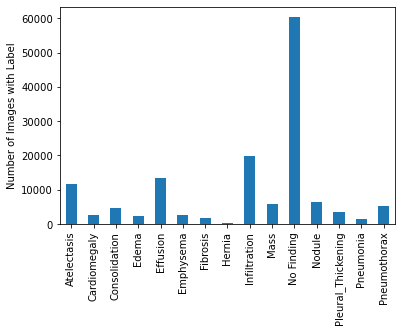

In [8]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

**OBSERVATION 2**  
This previous bar plot consolidate what we have just observed, that:  
1. "No Finding" has the most commmom ocurence
2. Infiltration is the seconds most present disease
3. Presence of Pneumonia is very low --> Data augumentation

Now let's explore the distrubution of the patients age distrubution in our dataset.

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

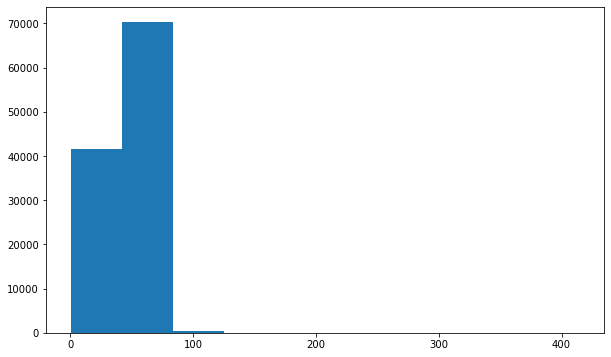

In [9]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'])

**OBSERVATION 3**  

From this previous chart we see that the patients age's is mostly distrubuted between 0 and 90.  
However we see also that the data contains ages higher than 120 reaching the age 400, which is most probably an issue in the dataset because no humans live for 400 years. This issue must be adressed in order to see the age distrubution more in detailed.  

In [10]:
number_of_deprecated_patient = len(all_xray_df[ all_xray_df["Patient Age"] > 120])
number_of_deprecated_patient

16

We see here that 16 patient has an age superior to 120.  
These entries must be removed.  
In the next cell we will create a new dataset with only patients with age lower than 120

In [11]:
df = all_xray_df[ all_xray_df["Patient Age"] < 120]

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

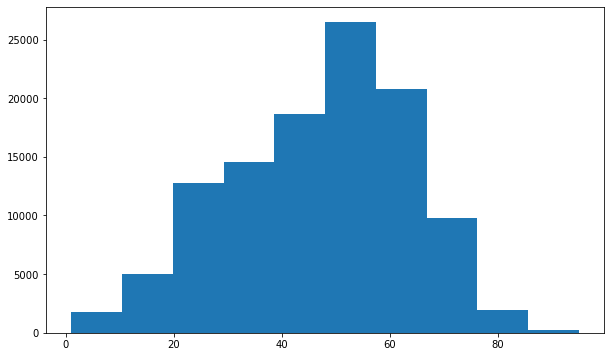

In [12]:
plt.figure(figsize=(10,6))
plt.hist(df["Patient Age"])

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

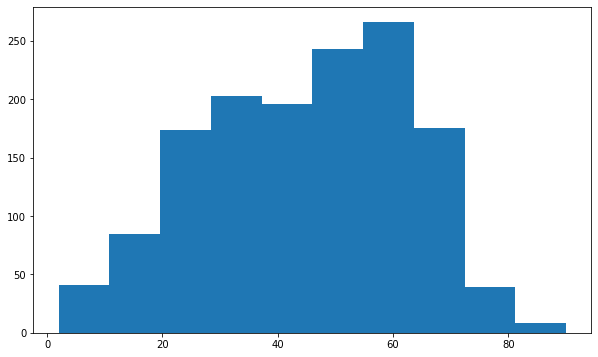

In [13]:
plt.figure(figsize=(10,6))
plt.hist(df["Patient Age"][df["Pneumonia"]==1])

**OBSERVATION 4**  
From the previous two histograms we can observe that:  
1. The most common ages of the Pneumonia Patients is betwwen [2,90]
2. The age distribution of the overall dataset is very similar to the one of Pneumonia patients 

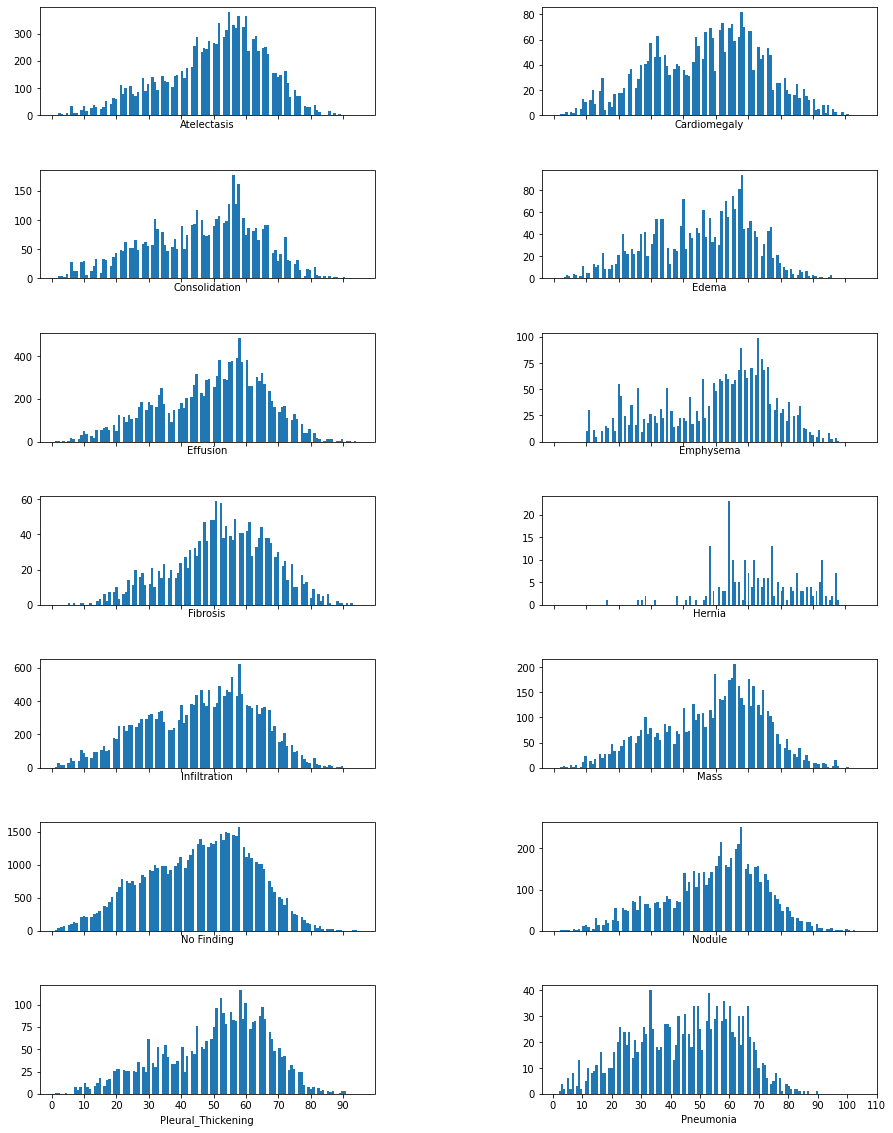

In [14]:
f, axes = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
f.subplots_adjust(hspace=0.5, wspace=0.5)
n_bins = 120
for label, ax in zip(all_labels,axes.flat):
    ax.hist(df["Patient Age"][df[label]==1],n_bins)
    ax.set_xlabel(label)
    ax.set_xticks(np.arange(0,120,10))
    ax.set_xticklabels(np.arange(0,120,10))
plt.show()

**OBSERVATION 5**  

Most of the deseases have a similar age distrubution, however some have some skewed distribution.  
This will not influence our model since we are concentrating only on Pneumonia patient.

## GENDER ANALYSIS

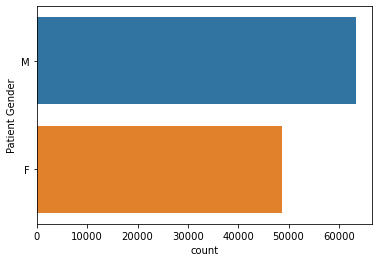

In [15]:
ax = sns.countplot(y="Patient Gender", data=df)

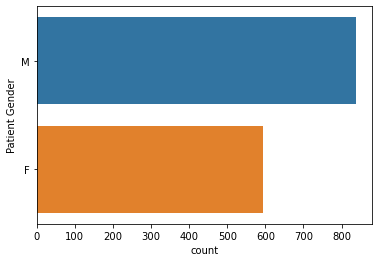

In [16]:
ax = sns.countplot(y="Patient Gender", data=df[df["Pneumonia"]==1])

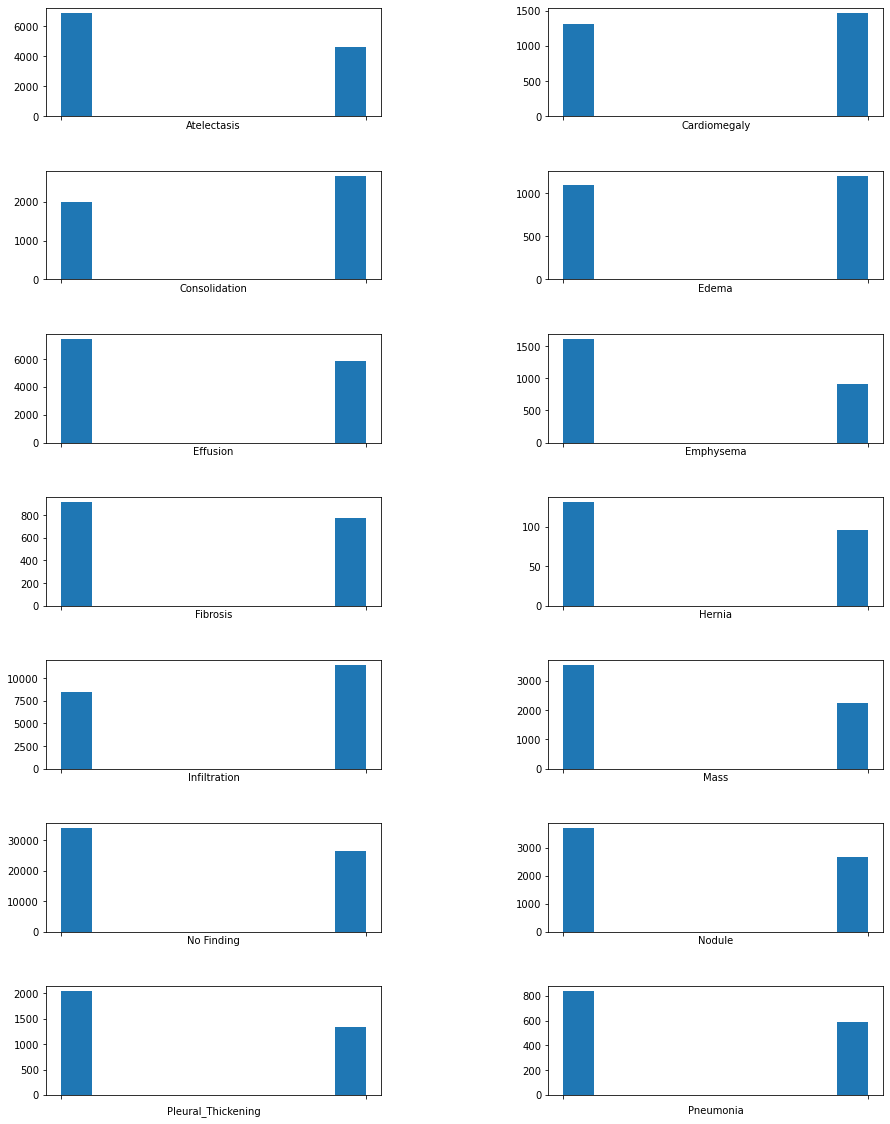

In [17]:
f, axes = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
f.subplots_adjust(hspace=0.5, wspace=0.5)
for label, ax in zip(all_labels,axes.flat):
    ax.hist(df["Patient Gender"][df[label]==1])
    #ax = sns.countplot(y="Patient Gender", data=df[df[label]==1],ax=ax)
    ax.set_xlabel(label)
    ax.set_xticks(["M","F"])
    ax.set_xticklabels([])

**OBSERVATION 6**  

From the previous histograms we see that:
1. The gender distribution of the overall data is very similar to the one of Pneumonia
2. There are a litlle bit more male than femal in the dataset
3. Some deseases have slight preference with femals than men like (Infiltration and consolidation)
4. The balance is acceptable

## Coexistance of Pneumonia with other deseases

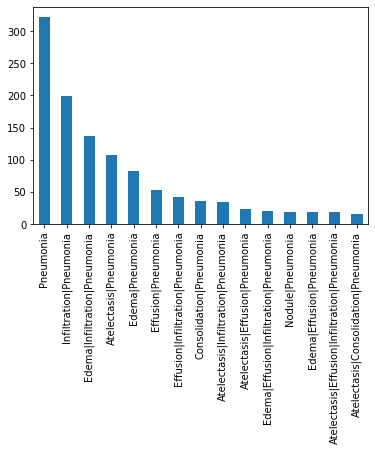

In [18]:
df[df.Pneumonia == 1]["Finding Labels"].value_counts()[:15].plot(kind='bar')

**OBSERVATION 7**  

Pneumonia is frequently combined with other deseases.  
The most frequent combination are:
1. Pneumonia + Infitration.
2. Pneumonia + Edema.
3. Pneumonia + Atelectasis

## Image analysis

In [19]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2939,00014438_005.png,Nodule,5,14438,054Y,F,PA,2892,2948,0.143,0.143
1940,00010103_010.png,Effusion|Infiltration|Pleural_Thickening,10,10103,071Y,M,PA,2992,2991,0.143,0.143
1988,00010384_029.png,Infiltration,29,10384,016Y,F,PA,2682,2401,0.143,0.143


In [20]:
# Helper function to reformat the "Patient Age" column to int
def replace_age(x):
    return int(x[:-1])

sample_df['Patient Age'] = sample_df['Patient Age'].map(replace_age)

In [21]:
# Expanding the "Finding Labels" to several columns
for c_label in all_labels:
    sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,77,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,79,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Helper function to add a column with the full image location path
image_folders = []

for i in range(1,13):
    image_folder = "images_" + str(i).zfill(3)
    image_folders.append(image_folder)

def construct_image_path(image_index):
    i = 0
    for im_folder in image_folders:
        image_path = os.path.sep.join(["/data",im_folder,"images",image_index])
        if os.path.exists(image_path):
            return image_path
        else:
            pass

sample_df["img_path"] = sample_df["Image Index"].map(construct_image_path)

In [23]:
sample_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,77,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,79,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000032_001.png


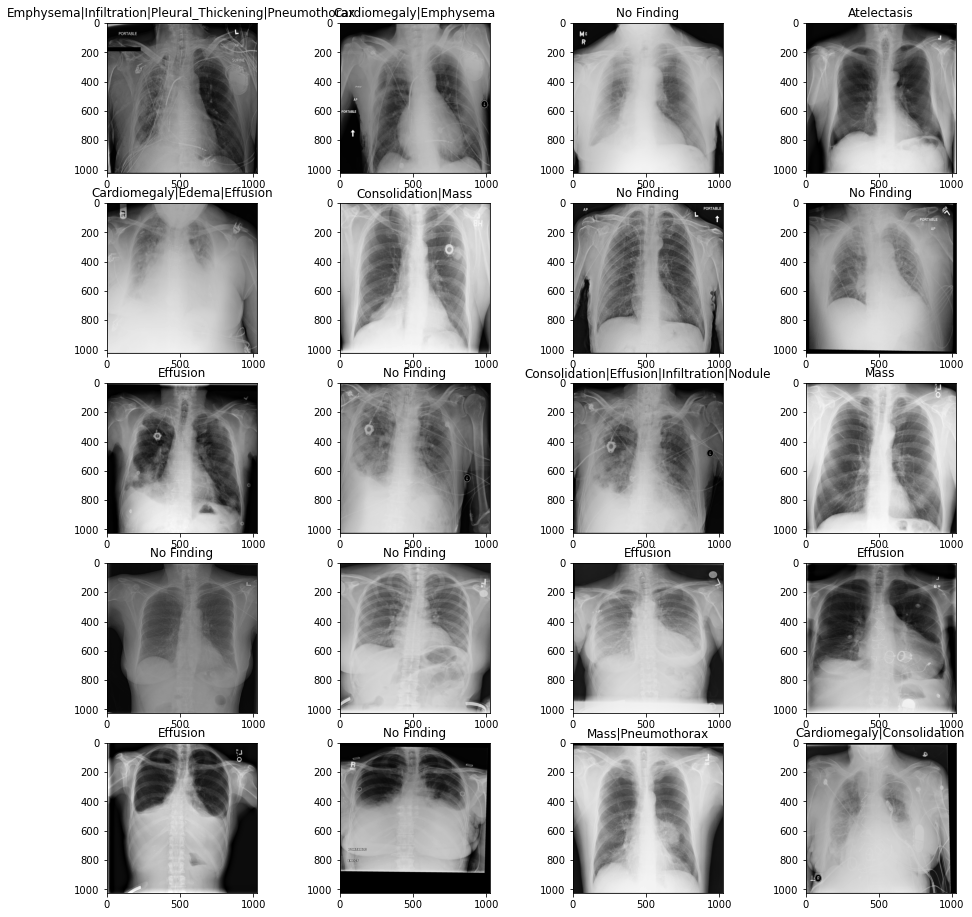

In [24]:
# Explore Random pictures
fig, m_axes = plt.subplots(5,4, figsize=(16,16))
m_axes = m_axes.flatten()
imgs = sample_df.img_path
i = 0

for img, ax in zip(imgs,m_axes):
    im = image.imread(img)
    ax.imshow(im,cmap='gray')
    ax.set_title(sample_df.iloc[i]["Finding Labels"])
    i += 1

#### Exploring some images  
From the sample that we see above we can be confident that:

1. Images looks quiet similar
2. No foreign bodies (at least not too much)
3. No grid artifacts

In [25]:
# Helper function to display the image and intensity histogram of it
def show_image_hist(image_path):
    f = plt.figure()
    f.set_figwidth(10)
    
    img = image.imread(image_path)
    
    fig1 = f.add_subplot(1,2,1)
    fig1.set_title("Original image")
    plt.imshow(img,cmap='gray')
    
    fig2 = f.add_subplot(1,2,2)
    fig2.set_title("Intensity histogram")
    plt.hist(img.ravel(),bins=128)
    
    plt.show()

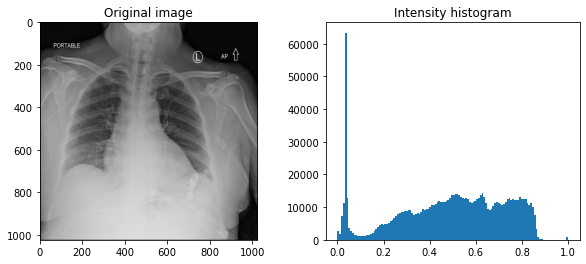

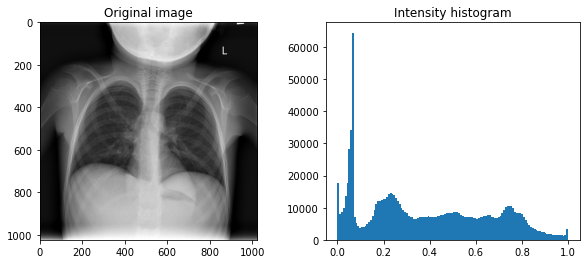

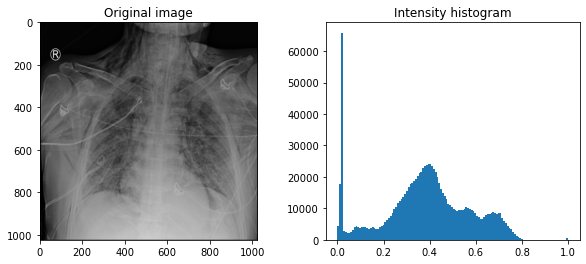

In [26]:
pneumonia_cases = sample_df[sample_df["Pneumonia"] == 1].sample(3)
for i in range(3):
    show_image_hist(pneumonia_cases.iloc[i]["img_path"])

Do all images with the same label have the same intensity profile? (lets explore some randome pictures)

From the pictures of Pneumonia patient above:
1. We can see that the all pictures have a peak intensity around 0 (this is due to the background in the image)
2. The three patients have two other peaks around 0.9 and 0.7

In [27]:
# Helper 
def get_intensities(label):
    intensities = []
    paths = sample_df[sample_df[label]==1]['img_path'].values
    print(f'Label: {label}, number of samples for intensity: {len(paths)}')
    for path in paths:
        data = image.imread(path)
        intensities.extend(data.flatten().tolist())
        return intensities

Label: Atelectasis, number of samples for intensity: 508
Label: Cardiomegaly, number of samples for intensity: 141
Label: Consolidation, number of samples for intensity: 226
Label: Edema, number of samples for intensity: 118
Label: Effusion, number of samples for intensity: 644
Label: Emphysema, number of samples for intensity: 127
Label: Fibrosis, number of samples for intensity: 84
Label: Hernia, number of samples for intensity: 13
Label: Infiltration, number of samples for intensity: 967
Label: Mass, number of samples for intensity: 284
Label: No Finding, number of samples for intensity: 3044
Label: Nodule, number of samples for intensity: 313
Label: Pleural_Thickening, number of samples for intensity: 176
Label: Pneumonia, number of samples for intensity: 62
Label: Pneumothorax, number of samples for intensity: 271


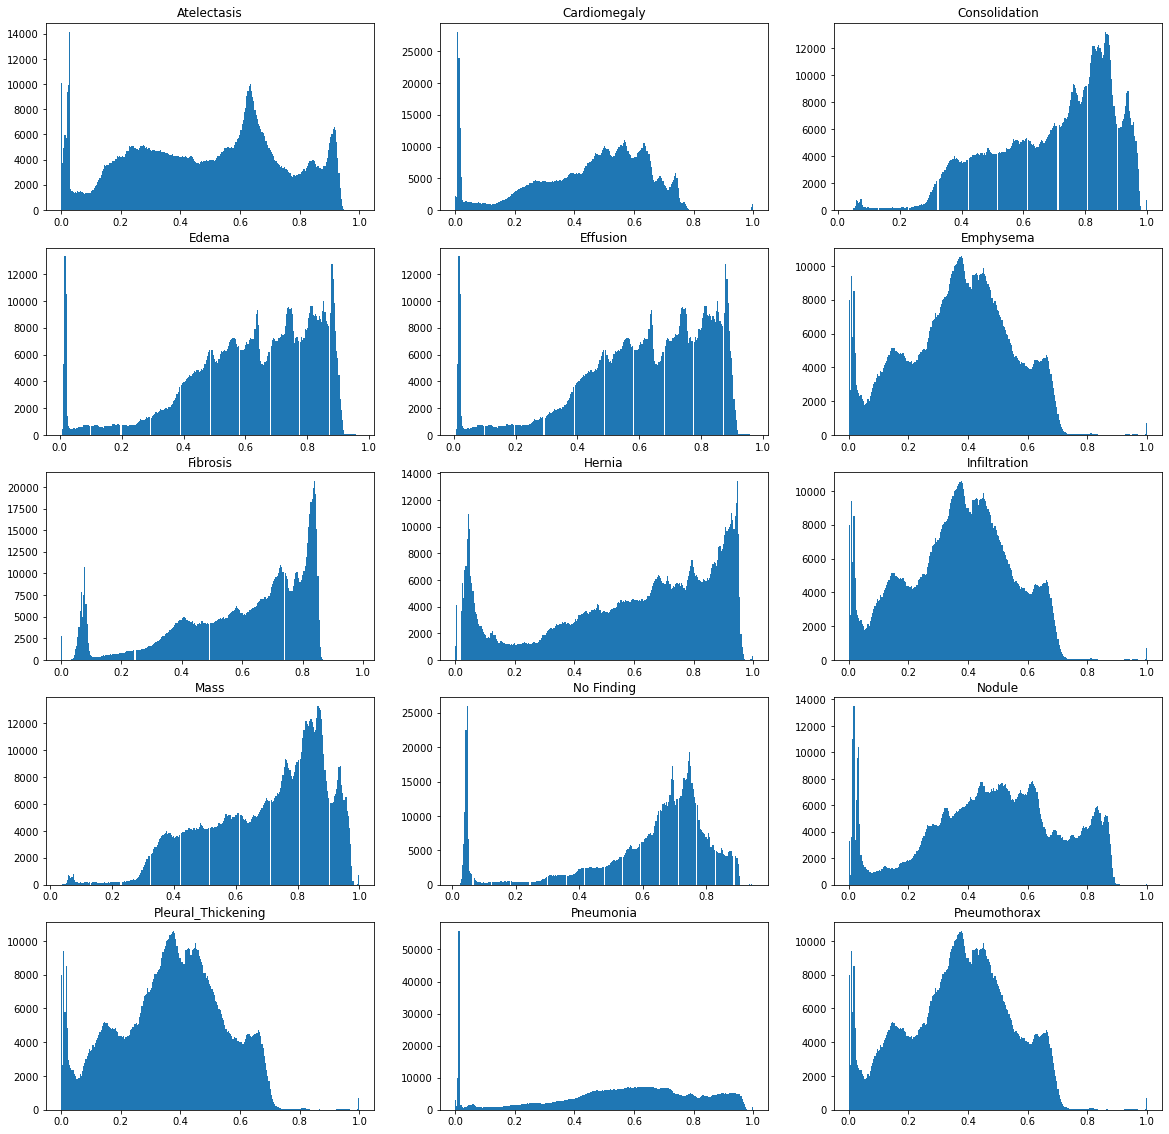

In [28]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
i = 0

for i,label in enumerate(all_labels):
    intensities = get_intensities(label)

    s = f.add_subplot(5, len(all_labels)/5, i+1)
    s.set_title(label)
    plt.hist(intensities, bins = 256)
    
plt.show()

from the above we see that:
1. Almost all the histograms tends to have the same distribution
2. The distribution of the overall Pneumonia data tend to be as explained before:
    * three peaks around 0, 0.7 and 0.8
  

In [29]:
def get_processed_intensities(label):
    intensities = []
    paths = sample_df[sample_df[label]==1]['img_path'].values
    print(f'Label: {label}, number of samples for intensity: {len(paths)}')
    for path in paths:
        data = image.imread(path)
        intensities.extend(data.flatten().tolist())
        mean = np.mean(intensities)
        std = np.std(intensities)
        return (intensities - mean) / std

Label: Atelectasis, number of samples for intensity: 508
Label: Cardiomegaly, number of samples for intensity: 141
Label: Consolidation, number of samples for intensity: 226
Label: Edema, number of samples for intensity: 118
Label: Effusion, number of samples for intensity: 644
Label: Emphysema, number of samples for intensity: 127
Label: Fibrosis, number of samples for intensity: 84
Label: Hernia, number of samples for intensity: 13
Label: Infiltration, number of samples for intensity: 967
Label: Mass, number of samples for intensity: 284
Label: No Finding, number of samples for intensity: 3044
Label: Nodule, number of samples for intensity: 313
Label: Pleural_Thickening, number of samples for intensity: 176
Label: Pneumonia, number of samples for intensity: 62
Label: Pneumothorax, number of samples for intensity: 271


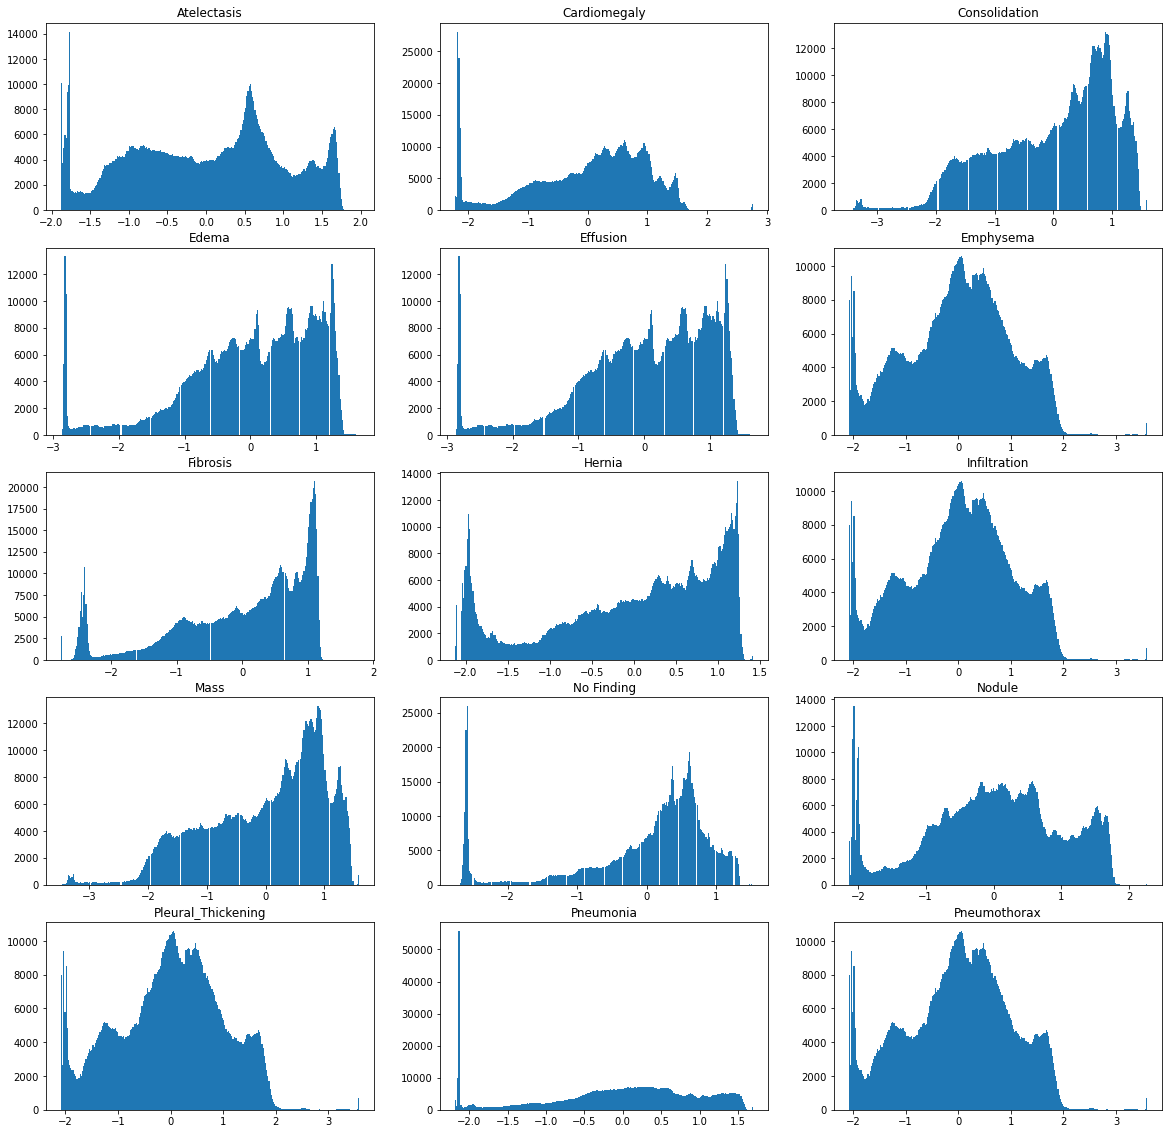

In [30]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
i = 0

for i,label in enumerate(all_labels):
    intensities = get_processed_intensities(label)

    s = f.add_subplot(5, len(all_labels)/5, i+1)
    s.set_title(label)
    plt.hist(intensities, bins = 256)
    
plt.show()

## Summary of obeservations:

1. FROM **OBSERVATION-1** & **OBSERVATION-2**:  
    - Most pictures are labeled as "No Findings" and the % of Pneumonia pictures is only 1.2%.  
==> This means that data augumentation will be needed in order to generate more inputs for our targeted disease.
    - Infiltration is the most present label in the dataset.  
==> Infiltration disease must be monitored closely on how it "could" impact our model.  <br /> 
2. FROM **OBSERVATION-3** & **OBSERVATION-4**:    
    - Some off values of the "patient age" are present in the dataset and data cleaning must be performed
    - The ditribution of the overall dataset is quiet similar to the one of Pneumonia patients
==> The model will be trained on patient with an age clipped between [2,90]. this must be taken into acount when making our model into production.  <br /> 
3. FROM **OBSERVATION-6**:  
    - The distribution of male and femal is fairly balanced.
    ==> model can be used on both femals and males
4. FROM **OBSERVARTION-7**:
    - The pneumonia disease can coexist with other diseases.
    - The three mains one are:
        1. Pneumonia + Infitration.
        2. Pneumonia + Edema.
        3. Pneumonia + Atelectasis  
        ==> This is a potentiel limitation to the model as our model will not be able to easly differentiate between pneumonia and the rest.